In [9]:
import pandas as pd
import glob
import os

# Path to the directory containing the CSV files
data_dir = "../../resources/data/costs/default/"
csv_files = glob.glob(os.path.join(data_dir, "costs_*.csv"))
csv_files = sorted(csv_files)
csv_files


['../../resources/data/costs/default/costs_2020.csv',
 '../../resources/data/costs/default/costs_2025.csv',
 '../../resources/data/costs/default/costs_2030.csv',
 '../../resources/data/costs/default/costs_2035.csv',
 '../../resources/data/costs/default/costs_2040.csv',
 '../../resources/data/costs/default/costs_2045.csv',
 '../../resources/data/costs/default/costs_2050.csv',
 '../../resources/data/costs/default/costs_2055.csv',
 '../../resources/data/costs/default/costs_2060.csv']

In [ ]:
import os
import pandas as pd

target_tech = "nuclear"             
target_param = "investment"      
new_value = 2700        

for file_path in csv_files:
    basename = os.path.basename(file_path)
    year = int(basename.split("_")[1].split(".")[0])  
    print(f"Processing {basename}...")

    df = pd.read_csv(file_path)

    mask = (df["technology"] == target_tech) & (df["parameter"] == target_param)
    if mask.any():
        old_values = df.loc[mask, "value"].tolist()
        df.loc[mask, "value"] = new_value
        print(f"  ✅ Modified {target_tech} {target_param}: {old_values} → {new_value}")
    else:
        print(f"  ⚠️  No {target_tech} {target_param} found in {basename}")

    df.to_csv(file_path, index=False)
    print(f"  💾 Saved updated file to {file_path}\n")


In [13]:
import pandas as pd
import glob
import os
import numpy as np

CNY_TO_EUR = 0.12
USD_TO_EUR = 0.90
ALL_YEARS = [2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060]

TARGET_TECH = "nuclear"
DEFAULT_DIR = "/p/tmp/yanleizh/pypsa-china-mineral/PyPSA-China-PIK/resources/data/costs/default/"
lit_path = "/p/tmp/yanleizh/pypsa-china-mineral/PyPSA-China-PIK/resources/data/costs/reference_costs/tech_costs_subset_litreview.csv"

# ============ 读取文献数据 ==============
lit_df = pd.read_csv(lit_path)
lit_subset = lit_df[
    (lit_df["technology"] == TARGET_TECH) &
    (lit_df["cost_type"] == "investment")
]

# 用户选择来源
print(f"\n📌 Available references for {TARGET_TECH}\n")
for i, row in lit_subset.iterrows():
    print(f"[{i}] {row['unit']:10s} | {row['reference']}")

choice = int(input("\nplease input number: "))
row = lit_subset.loc[choice]

# ============ 处理年份列 ==============
year_cols = [c for c in row.index if c.isdigit()]
avail_years = np.array([int(y) for y in year_cols])
raw_vals = pd.to_numeric(row[year_cols], errors="coerce").values

mask = ~np.isnan(raw_vals)
avail_years = avail_years[mask]
raw_vals = raw_vals[mask]

# 单位转换
unit = row["unit"].lower()
vals = raw_vals.copy()

if "cny" in unit:
    vals *= CNY_TO_EUR
elif "$" in unit or "usd" in unit:
    vals *= USD_TO_EUR

if "/mw" in unit:
    vals /= 1000  # → EUR/kW

# 插值
interp_vals = np.interp(ALL_YEARS, avail_years, vals)
interp_series = pd.Series(interp_vals, index=ALL_YEARS)

print("\n📈 Interpolated values:")
print(interp_series)

# ============ 修改 default 成本表 ==============
csv_files = sorted(glob.glob(os.path.join(DEFAULT_DIR, "costs_*.csv")))

for f in csv_files:
    df = pd.read_csv(f)

    # 从文件名获取 its_year
    fname = os.path.basename(f)            # costs_2030.csv
    its_year = int(fname.split("_")[1].split(".")[0])

    # 只保留当前文件对应年份
    df = df[df["year"] == its_year]

    # 修改或添加目标技术在该年份的值
    mask = (
        (df["technology"] == TARGET_TECH) &
        (df["parameter"] == "investment")
    )

    if mask.sum() > 0:
        df.loc[mask, "value"] = float(interp_series[its_year])
    else:
        new_row = {
            "technology": TARGET_TECH,
            "year": its_year,
            "parameter": "investment",
            "value": float(interp_series[its_year]),
            "unit": "EUR/kW",
            "source": "Literature interpolated",
            "further description": ""
        }
        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

    df.to_csv(f, index=False)
    print(f"✔ updated only year={its_year}: {fname}")

print("\n🎉 Completed. Each file now contains ONLY its year.\n")



📌 Available references for nuclear

[25] cny/kw     | Zhu et al.
[26] $/mw       | Switch-China
[27] eur/kw     | PyPSA-China

📈 Interpolated values:
2020    2340.0000
2025    2340.0000
2030    2340.0000
2035    2234.6130
2040    2129.2260
2045    2077.4352
2050    2025.6444
2055    1973.8542
2060    1922.0640
dtype: float64
✔ updated only year=2020: costs_2020.csv
✔ updated only year=2025: costs_2025.csv
✔ updated only year=2030: costs_2030.csv
✔ updated only year=2035: costs_2035.csv
✔ updated only year=2040: costs_2040.csv
✔ updated only year=2045: costs_2045.csv
✔ updated only year=2050: costs_2050.csv
✔ updated only year=2055: costs_2055.csv
✔ updated only year=2060: costs_2060.csv

🎉 Completed. Each file now contains ONLY its year.



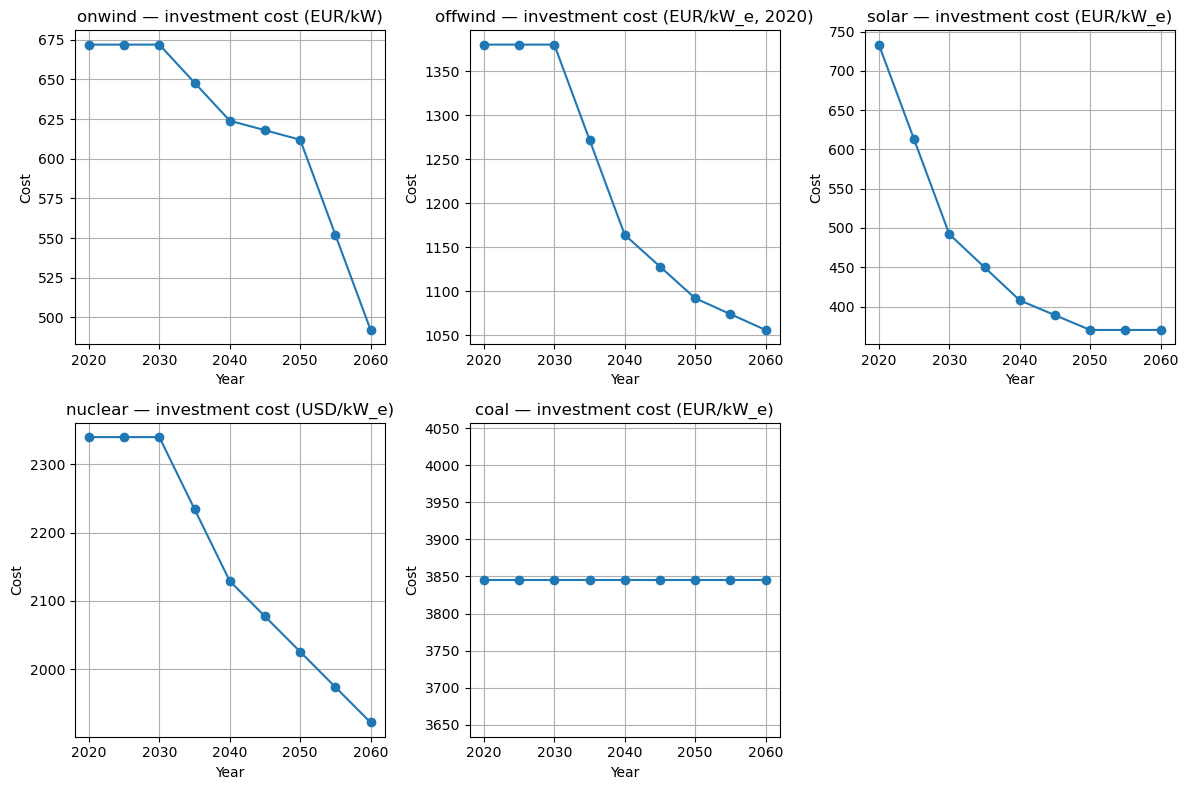

In [15]:
import math
import os
import pandas as pd
import matplotlib.pyplot as plt

# ====== 要绘图的技术 ======
plot_techs = ["onwind", "offwind", "solar", "nuclear", "coal"]

# ====== 存储所有年份的成本数据 ======
records = []   # year, tech, investment, unit

for file_path in csv_files:
    basename = os.path.basename(file_path)

    # 🔍 从文件名中提取年份，例如 cost_2030.csv
    year = int(basename.split("_")[1].split(".")[0])

    df = pd.read_csv(file_path)

    # 选 investment 参数 + 对应技术
    df_sel = df[
        (df["technology"].isin(plot_techs)) &
        (df["parameter"] == "investment")
    ][["technology", "value", "unit"]]

    for _, row in df_sel.iterrows():
        records.append([year, row["technology"], row["value"], row["unit"]])

# ====== 转为 DataFrame ======
df_plot = pd.DataFrame(records, columns=["year", "technology", "investment", "unit"])
df_plot = df_plot.sort_values("year")

# ====== 每行显示多少个子图 ======
cols = 3
rows = math.ceil(len(plot_techs) / cols)

plt.figure(figsize=(cols * 4, rows * 4))

for i, tech in enumerate(plot_techs):
    df_t = df_plot[df_plot["technology"] == tech]

    unit = df_t["unit"].iloc[0] if not df_t.empty else "unit unknown"

    ax = plt.subplot(rows, cols, i + 1)
    ax.plot(df_t["year"], df_t["investment"], marker="o")

    ax.set_title(f"{tech} — investment cost ({unit})")
    ax.set_xlabel("Year")
    ax.set_ylabel("Cost")
    ax.grid(True)

plt.tight_layout()
plt.show()


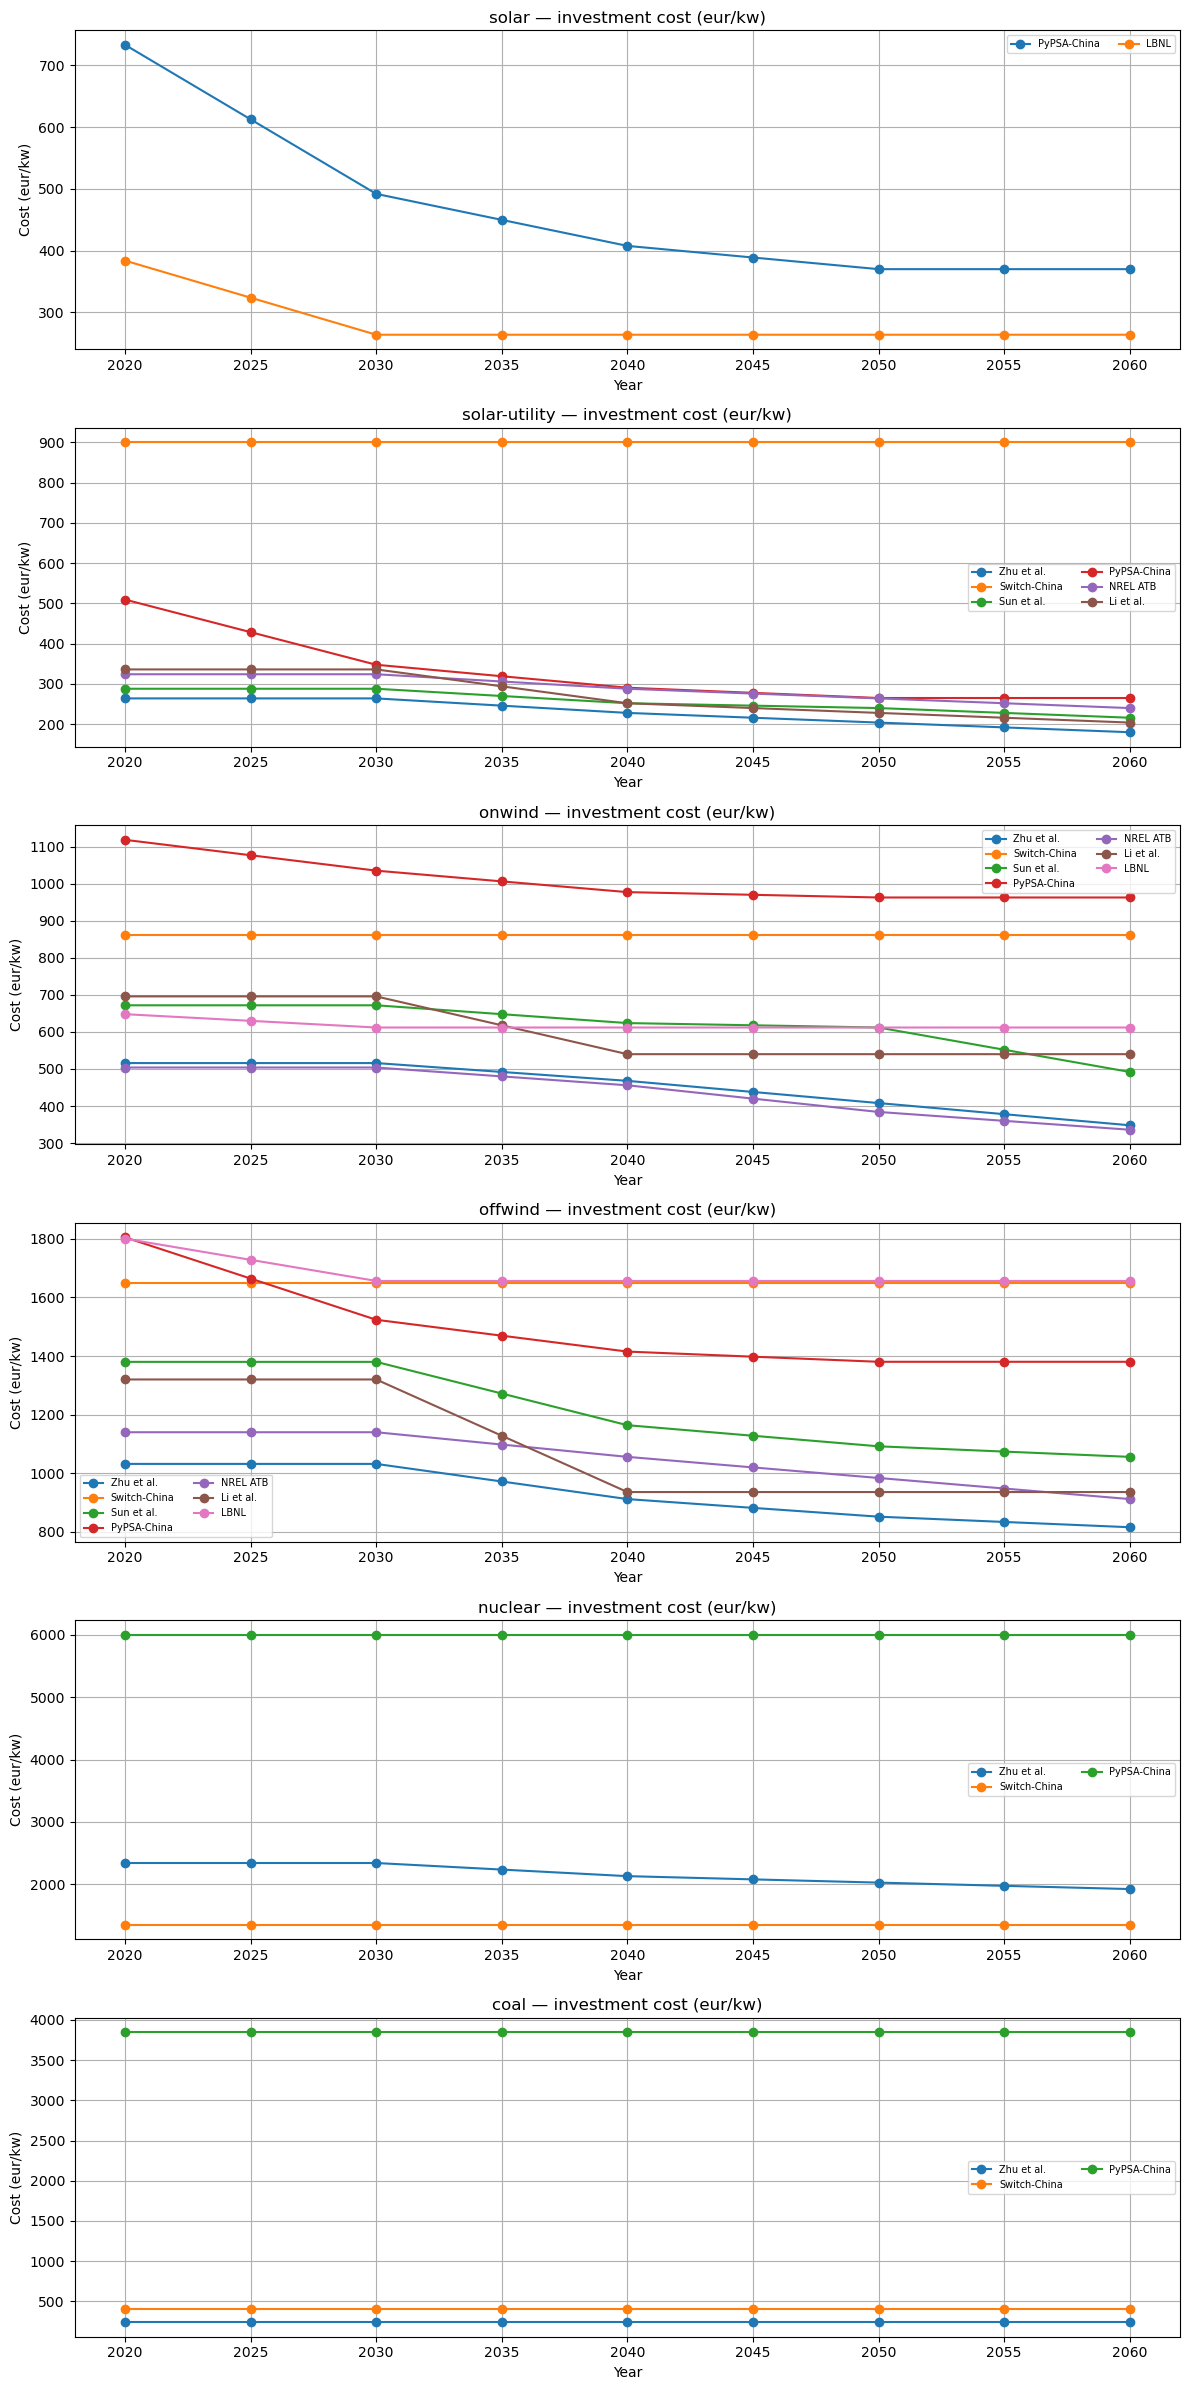

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ======================
# 配置（你可以修改）
# ======================
CNY_TO_EUR_2013 = 0.12
USD_TO_EUR_2013 = 0.9
ALL_YEARS = np.array([2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060])
plot_techs = ["solar", "solar-utility", "onwind", "offwind", "nuclear", "coal"]

lit_df = pd.read_csv("/p/tmp/yanleizh/pypsa-china-mineral/PyPSA-China-PIK/resources/data/costs/reference_costs/tech_costs_subset_litreview.csv")

# ======================
# 单位转换函数（最稳健版本）
# ======================
def convert_to_eur(value, unit_raw):

    unit = unit_raw.lower().strip()

    # ---- 1. 货币转换 ----
    if "cny" in unit:
        value = value * CNY_TO_EUR_2013
        unit = unit.replace("cny", "eur")

    if "$" in unit or "usd" in unit:
        value = value * USD_TO_EUR_2013
        unit = unit.replace("$", "eur").replace("usd", "eur")

    # ---- 2. 功率单位转换 ----
    # MW → kW
    if "/mw" in unit:
        value = value / 1000
        unit = unit.replace("/mw", "/kw")

    # MWh → kWh
    if "/mwh" in unit:
        value = value / 1000
        unit = unit.replace("/mwh", "/kwh")

    return value, unit


# ======================
# 绘图（每个技术一个子图）
# ======================
n = len(plot_techs)
plt.figure(figsize=(12, n * 4))

for i, tech in enumerate(plot_techs, 1):

    df_t = lit_df[
        (lit_df["technology"] == tech) &
        (lit_df["cost_type"] == "investment")
    ]

    ax = plt.subplot(n, 1, i)

    if df_t.empty:
        ax.set_title(f"{tech} (NO DATA)")
        continue

    for idx, row in df_t.iterrows():

        # ---- 找年份列 ----
        year_cols = [c for c in row.index if c.isdigit()]
        years = np.array([int(y) for y in year_cols])

        # ---- 安全转换数字（跳过 "-"）----
        vals = pd.to_numeric(row[year_cols], errors="coerce").values

        mask = ~np.isnan(vals)
        years = years[mask]
        vals = vals[mask]

        if len(vals) == 0:
            continue

        # ---- 单位转换 ----
        vals2 = []
        for v in vals:
            v2, unit_new = convert_to_eur(v, row["unit"])
            vals2.append(v2)
        vals2 = np.array(vals2)

        # ---- 插值到 ALL_YEARS ----
        interp_vals = np.interp(ALL_YEARS, years, vals2)

        # ---- 画线 ----
        ax.plot(ALL_YEARS, interp_vals, marker="o", label=row["reference"])

    ax.set_title(f"{tech} — investment cost ({unit_new})")
    ax.set_xlabel("Year")
    ax.set_ylabel(f"Cost ({unit_new})")
    ax.grid(True)
    ax.legend(fontsize=7, ncol=2)

plt.tight_layout()
plt.show()


In [ ]:
heat_rate = 300 # gce/kwh
gce_to_kwh = 8.14/1000
eta= 1/(gce_to_kwh*heat_rate)
eta

In [ ]:
heat_rate = 280 # gce/kwh
gce_to_kwh = 8.14/1000
eta= 1/(gce_to_kwh*heat_rate)
eta

In [ ]:
import numpy as np
# from heat rate coal eq/kWh (Xiang et al nat energy 2023) in 2020 to 52% 2060 (D KEA)
l = np.linspace(eta,0.52, len(csv_files))
years = [int(f.split('_')[-1].split('.csv')[0]) for f in csv_files]
new_values = dict(zip(years, l))
new_values

In [ ]:

for file_path in csv_files:
    # Extract year from filename
    basename = os.path.basename(file_path)
    year = basename.split("_")[1].split(".")[0]

    # Read CSV
    df = pd.read_csv(file_path)

    # Find the row for 'coal' and column for 'efficiency'
    mask = (df['technology'] == 'central coal CHP') & (df['parameter'] == 'efficiency')
    if mask.any():
        # Update the value to the new format: {year}:value
        old_value = df.loc[mask, 'value'].iloc[0]
        df.loc[mask, 'value'] = new_values[int(year)]*0.999
        df.loc[mask, "source"] = "Linear increase from Xiang et al nat energy 2023 to DKEA catalogue 2023 value for 2060"

        # # Overwrite the CSV file
        df.to_csv(file_path, index=False)

for file_path in csv_files:
    # Extract year from filename
    basename = os.path.basename(file_path)
    year = basename.split("_")[1].split(".")[0]

    # Read CSV
    df = pd.read_csv(file_path)

    # Find the row for 'coal' and column for 'efficiency'
    mask = (df['technology'] == 'coal') & (df['parameter'] == 'efficiency')
    if mask.any():
        # Update the value to the new format: {year}:value
        old_value = df.loc[mask, 'value'].iloc[0]
        df.loc[mask, 'value'] = new_values[int(year)]*1.001
        df.loc[mask, "source"] = "Linear increase from Xiang et al nat energy 2023 to DKEA catalogue 2023 value for 2060"

        # # Overwrite the CSV file
        df.to_csv(file_path, index=False)


In [ ]:

for file_path in csv_files:
    # Extract year from filename
    basename = os.path.basename(file_path)
    year = basename.split("_")[1].split(".")[0]

    # Read CSV
    df = pd.read_csv(file_path)

    # Find the row for 'coal' and column for 'efficiency'
    mask = (df['technology'] == 'central hydrogen CHP') & (df['parameter'] == 'efficiency')
    mask_gas = (df['technology'] == 'central gas CHP CC') & (df['parameter'] == 'efficiency')

    if mask.any():
        # Update the value to the new format: {year}:value
        old_value = df.loc[mask, 'value'].iloc[0]
        df.loc[mask, 'value'] = df.loc[mask_gas, 'value'].values*0.95
        df.loc[mask, "source"] = "gas CHP combined cycle efficiency *0.95 (based on a 60% H2 TEA https://www.mdpi.com/2071-1050/17/8/3369)"

        # # Overwrite the CSV file
        df.to_csv(file_path, index=False)

    # Read CSV
    df = pd.read_csv(file_path)

    # Find the row for 'coal' and column for 'efficiency'
    mask = (df['technology'] == 'central hydrogen CHP') & (df['parameter'] == 'investment')
    mask_gas = (df['technology'] == 'central gas CHP CC') & (df['parameter'] == 'investment')

    if mask.any():
        # Update the value to the new format: {year}:value
        old_value = df.loc[mask, 'value'].iloc[0]
        df.loc[mask, 'value'] = df.loc[mask_gas, 'value'].values*1.1
        df.loc[mask, "source"] = "10% markup on gas CC as per H2-Ready Gas-fired Power Plants, Christidis et al 2023, Reiner Lemoine Institut"

        # # Overwrite the CSV file
        df.to_csv(file_path, index=False)


    # Read CSV
    df = pd.read_csv(file_path)

    # Find the row for 'coal' and column for 'efficiency'
    mask = (df['technology'] == 'central hydrogen CHP') & (df['parameter'] == 'lifetime')
    mask_gas = (df['technology'] == 'central gas CHP CC') & (df['parameter'] == 'lifetime')

    if mask.any():
        # Update the value to the new format: {year}:value
        df.loc[mask, 'value'] = df.loc[mask_gas, 'value'].values-5
        df.loc[mask, "source"] = "5 year lifetime penalty vs gas - assumption"

        # # Overwrite the CSV file
        df.to_csv(file_path, index=False)



In [ ]:
eta_coal_boiler = 0.78 # efficiency guess of coal historical boilers *not suitable for pathway mode*
for file_path in csv_files:
    # Extract year from filename
    basename = os.path.basename(file_path)
    year = int(basename.split("_")[1].split(".")[0])
    
    # Read CSV
    df = pd.read_csv(file_path)
    df_ = pd.concat(
        [df, 
        pd.Series(["central coal boiler",year,"hist_efficiency",eta_coal_boiler,"p.u.", "expert guess for brownfield", "OPOP H4EKO class C"], index=df.columns).to_frame().T,
        pd.Series(["decentral coal boiler",year,"hist_efficiency",eta_coal_boiler,"p.u.", "expert guess for brownfield", "OPOP H4EKO class C"], index=df.columns).to_frame().T
        ])
    df_ = df_.drop_duplicates(subset=["technology", "parameter"], keep="first")
    df_.sort_values(by=["technology","year"], inplace=True)
    # # Overwrite the CSV file
    df_.to_csv(file_path, index=False)
    print("saved to ", file_path)


In [ ]:
df_.loc[df_.duplicated(subset=["technology", "parameter"], keep=False)]

In [ ]:
data = {}
for file_path in csv_files:
    # Extract year from filename
    basename = os.path.basename(file_path)
    year = basename.split("_")[1].split(".")[0]

    # Read CSV
    df = pd.read_csv(file_path)
    # Find the row for 'coal' and column for 'efficiency'
    mask = (df['technology'] == 'central gas CHP')
    if mask.any():
        # Update the value to the new format: {year}:value
        data[year] = df.loc[mask]
pd.concat(data.values()).query("parameter=='investment'").plot(kind="scatter", x="year", y="value")
pd.concat(data.values()).query("parameter=='efficiency'").plot(kind="scatter", x="year", y="value")

# FIX CC CHP

In [ ]:
# piecewise linear interpolation of DKEA values
dk_ea_invest = {
 2020: 0.88*1000,
 2030: 0.83*1000,
 2050: 0.8*1000}


In [ ]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

# Prepare data
x = np.array(list(dk_ea_invest.keys()))
y = np.array(list(dk_ea_invest.values()))

# Exponential decay function
def exp_decrease(x, a, b, c):
    return a * np.exp(b * (x - x[0])) + c

# Fit
popt, _ = curve_fit(exp_decrease, x, y, p0=(y[0], -0.1, 750))

# popt contains the fitted parameters a and b
a, b, c = popt
print(f"Fitted parameters: a={a}, b={b}")

# Example: predict for all years
years_fit = np.arange(2020, 2061, 5)
y_fit = exp_decrease(years_fit, a, b, c)

plt.scatter(dk_ea.keys(), dk_ea.values(), marker="D", color = "black")
plt.scatter(years_fit, y_fit, color='red', alpha=0.9)
fit = dict(zip(years_fit, y_fit))

In [ ]:
data = {}
for file_path in csv_files:
    # Extract year from filename
    basename = os.path.basename(file_path)
    year = basename.split("_")[1].split(".")[0]

    # Read CSV
    df = pd.read_csv(file_path)
    # Find the row for 'coal' and column for 'efficiency'
    mask = (df['technology'] == 'central gas CHP CC') & (df['parameter'] == 'investment')
    if mask.any():
        # Update the value to the new format: {year}:value
        # Find the row for 'coal' and column for 'efficiency'
        if mask.any():
            # Update the value to the new format: {year}:value
            old_value = df.loc[mask, 'value'].iloc[0]
            df.loc[mask, 'value'] = f"{fit[int(year)]:.2f}"
            df.loc[mask,"further description"] = "05 Gas turb. CC, steam extract.: Investment"

            # # Overwrite the CSV file
            df.to_csv(file_path, index=False)

In [ ]:
# piecewise linear interpolation of DKEA values
dk_ea = {
 2020: 0.59,
 2030: 0.61,
 2050: 0.63}
years = [2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060   ]
plt.plot(dk_ea.keys(), dk_ea.values(), marker="D", color = "black")
eff_interp = np.linspace(0.59,0.63,len(years)-2).tolist() + [0.63,0.63]
plt.plot(years, eff_interp, marker="o", color = "red")
eff_d = dict(zip(years, eff_interp))

In [ ]:
data = {}
for file_path in csv_files:
    # Extract year from filename
    basename = os.path.basename(file_path)
    year = basename.split("_")[1].split(".")[0]

    # Read CSV
    df = pd.read_csv(file_path)
    # Find the row for 'coal' and column for 'efficiency'
    mask = (df['technology'] == 'central gas CHP CC') & (df['parameter'] == 'efficiency')
    if mask.any():
        # Update the value to the new format: {year}:value
        # Find the row for 'coal' and column for 'efficiency'
        if mask.any():
            # Update the value to the new format: {year}:value
            old_value = df.loc[mask, 'value'].iloc[0]
            df.loc[mask, 'value'] = eff_d[int(year)]
            df.loc[mask,"further description"] = "05 Gas turb. CC, steam extract.:  Efficiency"

            # # Overwrite the CSV file
            df.to_csv(file_path, index=False)